# Brain Tumor Classification
## Objective:
The goal of this project is to classify MRI images of brain tumors into multiple categories using Machine Learning and Deep Learning models.
## Dataset:
- Source: [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- The dataset includes MRI images divided into different tumor types and "No Tumor" as a class.
- It contains 7023 instances for 4 targets :
1. **Gliome**  
2. **Méningiome**  
3. **Aucune Tumeur**  
4. **Hypophyse**  

This notebook includes:
- Data Preprocessing
- Model Implementation (Random Forest, Convolutionnal Neural Networks, )
- Evaluation and Comparison of Models


##### Realized by :  
- MESDOUR Yasmine.
- KOUHIL Zakaria.
- ZEMMOURI Yasmine.
- GHAZOUI Ilyas.

In [ ]:
import pandas as pd
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, AUC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score, RocCurveDisplay
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from skimage import io, color, transform

# Affichage en ligne des graphiques
%matplotlib inline

#### Linking images and their classes for the Training and Testing folders:

> Our data retrieved from Kaggle is organized into two folders: Training and Testing.  
Each of these folders contains four subfolders, one for each class.

- The following organization involves grouping all images into a single folder while keeping track of the labels in a CSV file.

In [ ]:
dossier_principal = 'dataset\\initial_dataset\\Testing'

data = []

for class_folder in os.listdir(dossier_principal):
    class_path = os.path.join(dossier_principal, class_folder)
    
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.endswith(('.jpg', '.png', '.jpeg')):
                data.append([image_name, class_folder])

df = pd.DataFrame(data, columns=['image_name', 'target']) 

csv_output = os.path.join(dossier_principal, 'images_classes_test.csv')
df.to_csv(csv_output, index=False)

print(f"Fichier CSV créé : {csv_output}")

Fichier CSV créé : dataset\initial_dataset\Testing\images_classes_test.csv


In [4]:
dossier_principal = 'dataset\\initial_dataset\\Training'

data = []

for class_folder in os.listdir(dossier_principal):
    class_path = os.path.join(dossier_principal, class_folder)
    
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.endswith(('.jpg', '.png', '.jpeg')):
                data.append([image_name, class_folder])

df = pd.DataFrame(data, columns=['image_name', 'target']) 

csv_output = os.path.join(dossier_principal, 'images_classes.csv')
df.to_csv(csv_output, index=False)

print(f"Fichier CSV créé : {csv_output}")

Fichier CSV créé : dataset\initial_dataset\Training\images_classes.csv


In [5]:
dossier = 'dataset'

df1 = pd.read_csv(os.path.join('dataset\\initial_dataset\\Training', 'images_classes.csv')) 
df2 = pd.read_csv(os.path.join('dataset\\initial_dataset\\Testing', 'images_classes_test.csv')) 

print("Nombre de lignes dans images_classes.csv :", df1.shape[0])
print("Nombre de lignes dans images_classes_test.csv:", df2.shape[0])

df_union = pd.concat([df1, df2], ignore_index=True)

print("Nombre de lignes après l'union :", df_union.shape[0])

# Sauvegarder le fichier résultant dans le même dossier
df_union.to_csv(os.path.join('dataset', 'metadata.csv'), index=False)


Nombre de lignes dans images_classes.csv : 5712
Nombre de lignes dans images_classes_test.csv: 1311
Nombre de lignes après l'union : 7023


# Data exploration and analysis :

In this section, we apply preprocessing to our data:  
- Resizing all images to a single uniform size.  
- Encoding the classes into numerical values.  
- Oversampling the data to achieve a balanced dataset.  

> As we are working with images, there are no missing data or important and pertinent features to consider: they are simply pixels.

#### Reading our files:  

In [34]:
data = pd.read_csv("dataset/metadata.csv")
image_folder = "dataset/consolidated_dataset"
output_folder = "dataset/processed_dataset"
os.makedirs(output_folder, exist_ok=True)

print(data.head())
print(data.info())
print(data['target'].value_counts()) 

         image_name  target
0  Tr-glTr_0000.jpg  glioma
1  Tr-glTr_0001.jpg  glioma
2  Tr-glTr_0002.jpg  glioma
3  Tr-glTr_0003.jpg  glioma
4  Tr-glTr_0004.jpg  glioma
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  7023 non-null   object
 1   target      7023 non-null   object
dtypes: object(2)
memory usage: 109.9+ KB
None
target
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


In [19]:
missing_images = [img for img in data['image_name'] if not os.path.exists(os.path.join(image_folder, img))]
print(f"Nombre d'images manquantes : {len(missing_images)}")
if missing_images:
    print(f"Images manquantes : {missing_images}")

Nombre d'images manquantes : 0


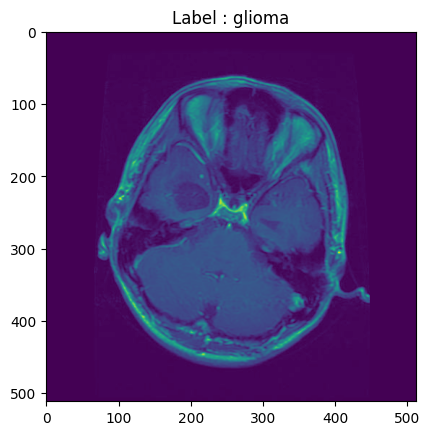

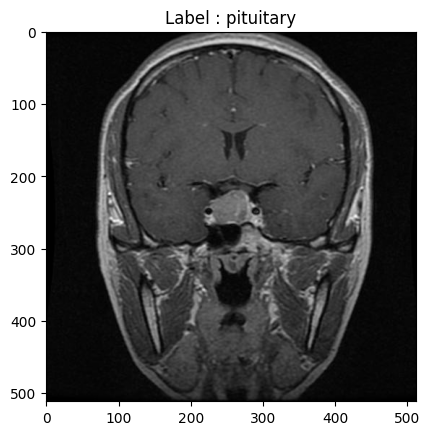

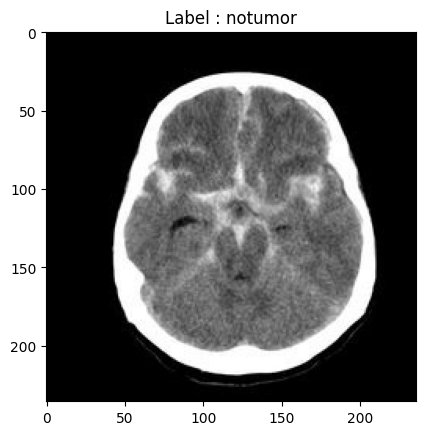

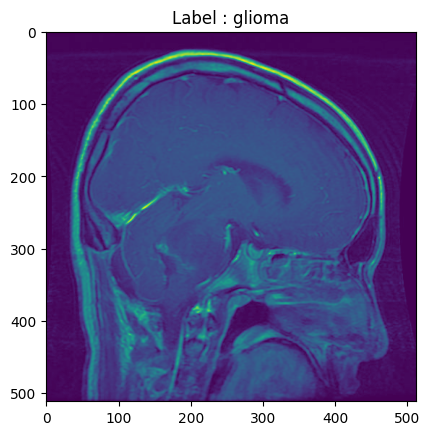

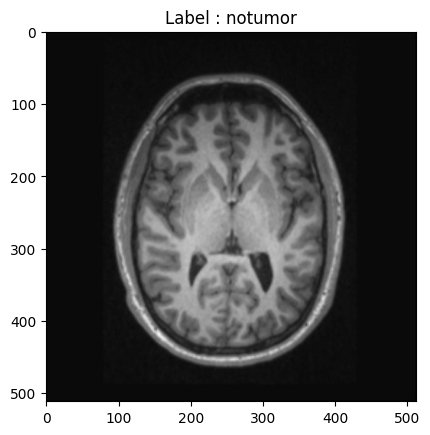

In [20]:
sample_images = data.sample(5)
for _, row in sample_images.iterrows():
    img_path = os.path.join(image_folder, row['image_name'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label : {row['target']}")
    plt.show()

#### Checking the size of the images:  

In [5]:
image_sizes = []

for img_name in data['image_name']:
    img_path = os.path.join(image_folder, img_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

print(set(image_sizes)) 


{(491, 624), (206, 244), (409, 442), (503, 369), (430, 483), (728, 725), (201, 251), (289, 354), (554, 554), (236, 226), (214, 216), (229, 214), (733, 781), (229, 223), (235, 257), (411, 501), (329, 310), (645, 439), (434, 512), (227, 262), (528, 528), (590, 332), (209, 241), (407, 485), (630, 423), (300, 359), (236, 203), (502, 502), (236, 221), (236, 239), (550, 664), (226, 213), (411, 496), (1024, 830), (374, 456), (235, 261), (329, 314), (355, 452), (626, 686), (276, 326), (300, 345), (210, 213), (1920, 1080), (359, 449), (201, 250), (221, 228), (192, 192), (236, 216), (225, 225), (202, 223), (410, 490), (605, 613), (216, 234), (208, 248), (350, 350), (444, 506), (450, 446), (442, 442), (339, 340), (534, 674), (257, 307), (402, 396), (341, 377), (224, 219), (421, 486), (926, 649), (213, 237), (341, 395), (825, 993), (236, 220), (447, 251), (235, 233), (622, 777), (494, 600), (208, 243), (228, 221), (239, 248), (600, 605), (314, 260), (201, 249), (341, 372), (224, 223), (212, 236), 

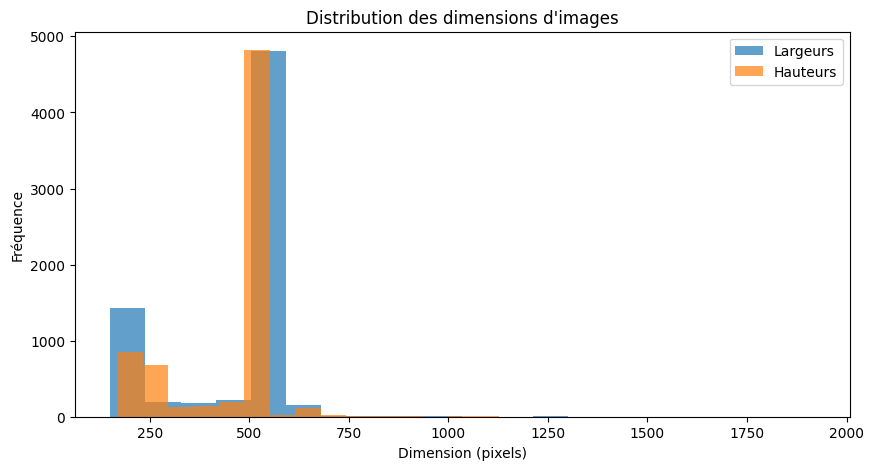

In [6]:
# Distribution des tailles d'images
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.7, label='Largeurs')
plt.hist(heights, bins=20, alpha=0.7, label='Hauteurs')
plt.legend()
plt.title("Distribution des dimensions d'images")
plt.xlabel("Dimension (pixels)")
plt.ylabel("Fréquence")
plt.show()

Since the sizes are not uniform, we apply a resize to (128,128) to create a consistent dataset.

In [21]:
def preprocess_image(image_path, target_size):
    try:
        # Charger l'image
        image = Image.open(image_path).convert("RGB")
    
        
        image = ImageOps.fit(image, target_size, method=Image.Resampling.LANCZOS)
        
        return image
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        return None

In [22]:
target_size = (128, 128)
for image_name in data['image_name']:
    image_path = os.path.join(image_folder, image_name)
    
    if os.path.exists(image_path):
        processed_image = preprocess_image(image_path, target_size)
        if processed_image:
            output_image_path = os.path.join(output_folder, image_name)
            processed_image.save(output_image_path)
            #print(f"Image sauvegardée : {output_image_path}")
    else:
        print(f"Image manquante : {image_name}")

print("Prétraitement terminé et images sauvegardées dans 'processed_dataset'.")

Prétraitement terminé et images sauvegardées dans 'processed_dataset'.


#### Encoding labels into numerical values:  

In [35]:
class_mapping = {
    'notumor': 0,
    'pituitary': 1,
    'meningioma': 2,
    'glioma': 3
}
data['target'] = data['target'].map(class_mapping)
data.to_csv("dataset/metadata_encoded.csv", index=False)
print(data.head())

         image_name  target
0  Tr-glTr_0000.jpg       3
1  Tr-glTr_0001.jpg       3
2  Tr-glTr_0002.jpg       3
3  Tr-glTr_0003.jpg       3
4  Tr-glTr_0004.jpg       3


#### Balancing the dataset:  

In [36]:
class_counts = data['target'].value_counts()
print("Répartition des classes :")
print(class_counts)

Répartition des classes :
target
0    2000
1    1757
2    1645
3    1621
Name: count, dtype: int64


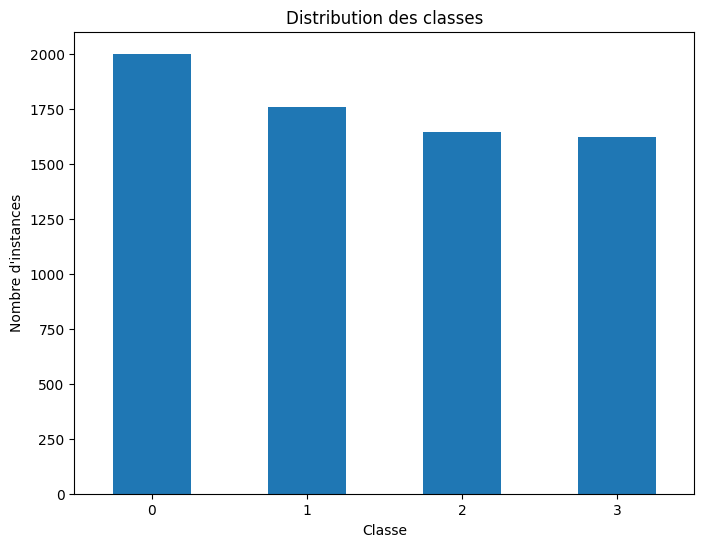

In [25]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'instances")
plt.xticks(rotation=0)
plt.show()

We can observe that our data is not balanced, as the number of images for each class is different. For some models, this discrepancy does not pose an issue.

> In our case, we prefer to apply oversampling to have 2000 images per class, in order to avoid affecting the performance of the models.

> To achieve this, we apply rotations to existing images in our dataset to reach 2000 images.

In [27]:
def rotate_image(image_path, angle):
    with Image.open(image_path) as img:
        rotated_img = img.rotate(angle)  # Rotation de l'image
        return rotated_img

In [ ]:
balanced_folder = "dataset/balanced_dataset"
os.makedirs(balanced_folder, exist_ok=True)
max_class_count = data['target'].value_counts().max()
balanced_data = []

'dataset/balanced_dataset'

In [41]:
# Traiter chaque classe pour équilibrer les données
for target in data['target'].unique():
    # Filtrer les images de la classe actuelle
    class_data = data[data['target'] == target]
    current_class_count = len(class_data)
    
    # Ajouter les images originales dans les données équilibrées
    for index, row in class_data.iterrows():
        balanced_data.append({'image_name': row['image_name'], 'target': row['target']})
    
    # Si la classe est sous-représentée, on fait une augmentation par rotation
    if current_class_count < max_class_count:
        # Calculer combien d'images supplémentaires sont nécessaires
        num_needed = max_class_count - current_class_count
        
        # Ajouter des images rotatées pour équilibrer la classe
        for index, row in class_data.iterrows():
            image_name = row['image_name']
            src_path = os.path.join(output_folder, image_name)
            
            # Créer les nouvelles images avec des rotations (par exemple, 90, 180, 270 degrés)
            for angle in [90, 180, 270]:
                rotated_img = rotate_image(src_path, angle)
                rotated_image_name = f"rotated_{angle}_{image_name}"
                rotated_image_path = os.path.join(balanced_folder, rotated_image_name)
                
                # Sauvegarder l'image dans le dossier
                rotated_img.save(rotated_image_path)
                
                # Ajouter l'image à la liste des données équilibrées
                balanced_data.append({'image_name': rotated_image_name, 'target': target})
                
                # Si on a assez d'images pour cette classe, arrêter la génération
                if len([item for item in balanced_data if item['target'] == target]) >= max_class_count:
                    break
            
            # Si le nombre souhaité d'images est atteint, arrêter
            if len([item for item in balanced_data if item['target'] == target]) >= max_class_count:
                break

In [ ]:
balanced_df = pd.DataFrame(balanced_data)

for index, row in balanced_df.iterrows():
    image_name = row['image_name']
    src_path = os.path.join(output_folder, image_name)
    dest_path = os.path.join(balanced_folder, image_name)
    
    if not os.path.exists(dest_path):
        shutil.copy(src_path, dest_path)

balanced_df.to_csv("dataset/balanced_metadata.csv", index=False)

print(f"Dataset équilibré créé dans {balanced_folder} et étiquettes sauvegardées dans 'balanced_metadata.csv'.")

Dataset équilibré créé dans dataset/balanced_dataset et étiquettes sauvegardées dans 'balanced_metadata.csv'.


In [45]:
data= balanced_df

In [46]:
print("Répartition des classes après rééquilibrage :")
print(data['target'].value_counts())

Répartition des classes après rééquilibrage :
target
3    2000
2    2000
0    2000
1    2000
Name: count, dtype: int64


Min: 0, Max: 255
Moyenne: 48.107037322998046, Écart-type: 51.478289924876975


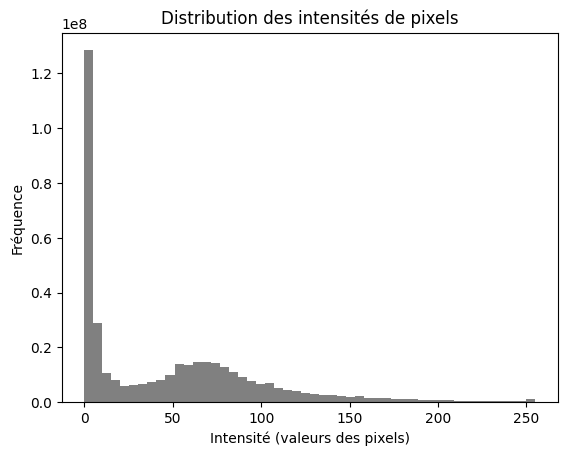

In [47]:
pixel_values = []

for img_name in data['image_name']:
    img_path = os.path.join(balanced_folder, img_name)
    with Image.open(img_path) as img:
        pixel_values.append(np.array(img).flatten())

pixel_values = np.concatenate(pixel_values)

# Statistiques sur les pixels
print(f"Min: {pixel_values.min()}, Max: {pixel_values.max()}")
print(f"Moyenne: {pixel_values.mean()}, Écart-type: {pixel_values.std()}")

# Histogramme des valeurs de pixels
plt.hist(pixel_values, bins=50, color='gray')
plt.title("Distribution des intensités de pixels")
plt.xlabel("Intensité (valeurs des pixels)")
plt.ylabel("Fréquence")
plt.show()


# Models Used:  

## 1- Convolutional Neural Network (CNN) Model

### Overview
This section outlines the implementation of a Convolutional Neural Network (CNN) designed for multiclass classification. The model architecture is created using Keras's `Sequential` API, and the following components are included:

1. **Convolutional Layers**:
   - Three convolutional layers.
   - Increasing filter sizes to extract hierarchical features.
   - Each convolutional layer is followed by max pooling for dimensionality reduction.

2. **Fully Connected Layers**:
   - A dense layer with 128 neurons and a dropout layer for regularisation.
   - Final dense layer with softmax activation for multiclass classification.

3. **Configurable Parameters**:
   - **Filters**: Adjustable number of convolution filters.
   - **Kernel Size**: Configurable kernel size for convolutions.
   - **Dropout Rate**: Regularisation parameter to mitigate overfitting.
   - **Optimizer**: Selectable optimiser (`adam`, `sgd`, `rmsprop`).
   - **Activation**: Selectable activation function (`ReLU`, `tanh`, `elu`).

4. **Metrics**:
   - `Accuracy`: For overall classification performance.
   - `Recall`: To measure sensitivity for true positive detection.
   - `AUC`: Area Under Curve for robust evaluation of classification capabilities.


### Retrieving the data:  

In [ ]:
metadata = pd.read_csv('../dataset/balanced_metadata.csv')
metadata

,image_name,target
0,Tr-glTr_0000.jpg,3
1,Tr-glTr_0001.jpg,3
2,Tr-glTr_0002.jpg,3
3,Tr-glTr_0003.jpg,3
4,Tr-glTr_0004.jpg,3
...,...,...
7995,rotated_180_Tr-pi_0079.jpg,1
7996,rotated_270_Tr-pi_0079.jpg,1
7997,rotated_90_Tr-pi_0080.jpg,1
7998,rotated_180_Tr-pi_0080.jpg,1


### Normalizing the images and encoding the labels:  

In [ ]:
image_folder = '../dataset/balanced_dataset/'
images = []
labels = []
for i, row in metadata.iterrows():
    img_path = os.path.join(image_folder, row['image_name'])
    img = load_img(img_path, target_size=(128, 128))
    images.append(img_to_array(img))
    labels.append(row['target'])

images = np.array(images) / 255.0  # Normalisation
labels = np.array(labels)
print(labels.shape)
print(labels[:10])

(8000,)
[3 3 3 3 3 3 3 3 3 3]


In [5]:
labels = to_categorical(labels, num_classes=4)
print(images.shape)  
print(labels.shape)

(8000, 128, 128, 3)
(8000, 4)


### Defining the architecture of our model:  

In [6]:
def build_cnn_model(input_shape=(128, 128, 3), num_classes=4, optimizer='adam',
                    dropout_rate=0.5, activation='relu', filters=32, kernel_size=(3, 3)):
    model = Sequential()

    # Première couche convolutionnelle
    model.add(Conv2D(filters, kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Deuxième couche convolutionnelle
    model.add(Conv2D(filters * 2, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Troisième couche convolutionnelle
    model.add(Conv2D(filters * 4, kernel_size, activation=activation))
    model.add(MaxPooling2D((2, 2)))

    # Aplatir les résultats des couches précédentes
    model.add(Flatten())

    # Couches entièrement connectées
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))  # Dropout pour éviter l'overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Classification multi-classe

    # Choisir l'optimiseur basé sur l'argument
    if optimizer == 'adam':
        optimizer_instance = Adam()
    elif optimizer == 'sgd':
        optimizer_instance = SGD()
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop()

    # Compiler le modèle avec les métriques supplémentaires
    model.compile(optimizer=optimizer_instance, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Recall(), AUC()])

    return model

### Defining the parameters to test for our GridSearch:  

In [13]:
# Grid search des paramètres
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],  # Optimiseur à tester
    'dropout_rate': [0.3, 0.5, 0.7],  # Taux de dropout
    'activation': ['relu', 'tanh', 'elu'],  # Fonction d'activation des couches
    'filters': [32],  # Nombre de filtres dans les couches convolutionnelles
    'kernel_size': [(3, 3)],  # Taille des noyaux de convolution
    'batch_size': [16, 32],  # Taille des mini-batchs
    'epochs': [5, 10]  # Nombre d'époques
}

### Split the dataset into 80/20 for train/test :

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Apply a GridSearch with a 3-fold cross-validation :

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.5, activation='relu', filters=32, kernel_size=(3, 3)):
    return build_cnn_model(input_shape=(128, 128, 3),
                           num_classes=4,
                           optimizer=optimizer,
                           dropout_rate=dropout_rate,
                           activation=activation,
                           filters=filters,
                           kernel_size=kernel_size)

In [ ]:
model = KerasClassifier(model=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

In [ ]:
grid_result = grid.fit(X_train, y_train)
print("\n[INFO] Recherche terminée.")
print(f"Meilleure combinaison de paramètres : {grid_result.best_params_}")
print(f"Meilleur score  : {grid_result.best_score_:.4f}")


[INFO] Test de la combinaison 1/108:
  Batch size: 16
  Epochs size: 5
  Optimizer: adam
  Dropout rate: 0.3
  Activation: relu
  Filters: 32
  Kernel size: (3, 3)
  Batch size: 16
  Epochs: 5
    Fold 1/3 : Entraînement et évaluation en cours...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


I0000 00:00:1733771826.191872    8983 service.cc:145] XLA service 0x781c300020e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733771826.191954    8983 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 24/267 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2582 - auc: 0.5509 - loss: 1.5614 - recall: 0.0195

I0000 00:00:1733771829.408641    8983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5333 - auc: 0.8010 - loss: 1.0289 - recall: 0.3529
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8012 - auc: 0.9527 - loss: 0.5208 - recall: 0.7475
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8706 - auc: 0.9800 - loss: 0.3292 - recall: 0.8612
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9123 - auc: 0.9899 - loss: 0.2283 - recall: 0.9049
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9400 - auc: 0.9950 - loss: 0.1571 - recall: 0.9371
    Fold 1/3 terminé : précision = 0.9213
    Fold 2/3 : Entraînement et évaluation en cours...
Epoch 1/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5661 - auc_1: 0.8163 - loss: 0.9914 - recall_1: 0.3719
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8111 - auc_1: 0.9572 - loss: 0.4907 - recall_1: 0.7746
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8639 - auc_1: 0.9775 - loss

In [ ]:
best_model = grid_result.best_estimator_
best_params = grid_result.best_params_
print("Meilleure combinaison de paramètres : ", best_params)
print(f"Meilleur score  : {grid_result.best_score_:.4f}")

Meilleure combinaison de paramètres :  {'optimizer': 'adam', 'dropout_rate': 0.5, 'activation': 'relu', 'filters': 32, 'kernel_size': (3, 3), 'batch_size': 16, 'epochs': 10}
Meilleur score moyen :  0.9289


In [30]:
best_model = build_cnn_model(input_shape=(128, 128, 3), num_classes=4, 
                              optimizer=best_params['optimizer'],
                              dropout_rate=best_params['dropout_rate'], activation=best_params['activation'], 
                              filters=best_params['filters'], kernel_size=best_params['kernel_size'])

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

test_score = best_model.evaluate(X_test, y_test)
print(f"Score sur le jeu de test : {test_score[1]}") 

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5557 - auc_4: 0.8128 - loss: 1.0044 - recall_4: 0.3612
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7992 - auc_4: 0.9517 - loss: 0.5307 - recall_4: 0.7623
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8593 - auc_4: 0.9745 - loss: 0.3731 - recall_4: 0.8408
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8988 - auc_4: 0.9852 - loss: 0.2825 - recall_4: 0.8878
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9149 - auc_4: 0.9899 - loss: 0.2274 - recall_4: 0.9054
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9360 - auc_4: 0.9939 - loss: 0.1722 - recall_4: 0.9308
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9448 - auc_4: 0.9958 - loss: 0.1439 - recall_4: 0.9420
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9563 - auc_4: 0.9970 - loss: 0.1177 - recall_4: 0.9532
Epoch 9/10
400/400 ━━━━━━━━━━━━━

In [ ]:
best_model.save("../models/best_cnn_model.h5")
print("Modèle sauvegardé sous le nom 'best_cnn_model.h5'")

Modèle sauvegardé sous le nom 'best_cnn_model.h5'


In [32]:
results = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Loss sur le jeu de test : {results[0]:.4f}")
print(f"Accuracy : {results[1]:.4f}")
print(f"Recall : {results[2]:.4f}")
print(f"AUC : {results[3]:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9588 - auc_4: 0.9907 - loss: 0.1849 - recall_4: 0.9588
Loss sur le jeu de test : 0.1935
Accuracy : 0.9519
Recall : 0.9519
AUC : 0.9901


In [33]:
y_pred_prob = best_model.predict(X_test) 
y_pred = np.argmax(y_pred_prob, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


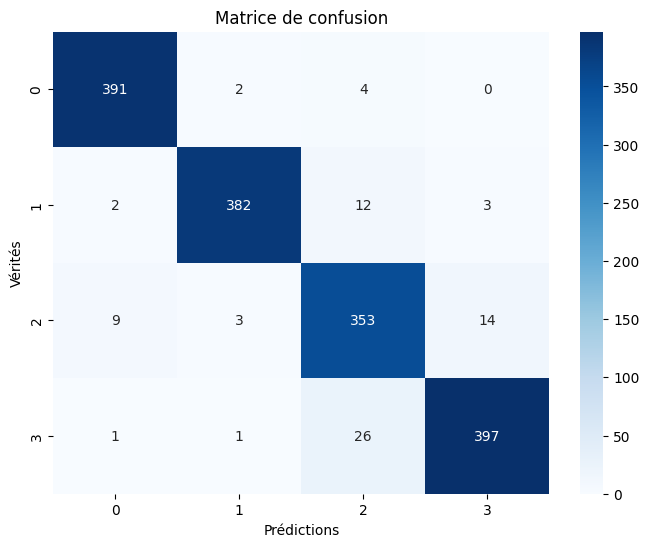

In [36]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

In [37]:
print("\nRapport de classification :\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred))


Rapport de classification :

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       397
           1       0.98      0.96      0.97       399
           2       0.89      0.93      0.91       379
           3       0.96      0.93      0.95       425

    accuracy                           0.95      1600
   macro avg       0.95      0.95      0.95      1600
weighted avg       0.95      0.95      0.95      1600



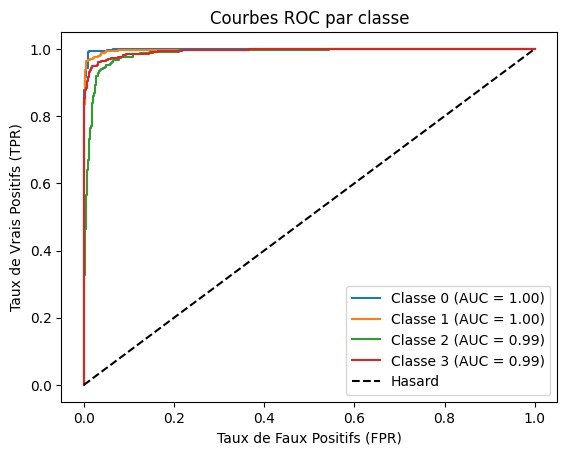

In [38]:
# AUC-ROC pour chaque classe
auc_scores = []
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {auc:.2f})')

# Courbe ROC globale
plt.plot([0, 1], [0, 1], 'k--', label='Hasard')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC par classe')
plt.legend(loc='best')
plt.show()

In [41]:
# AUC moyenne
auc_macro = np.mean(auc_scores)
print(f"AUC moyenne (macro) : {auc_macro:.4f}")

AUC moyenne (macro) : 0.9941


> We can see that the model performs very well in terms of accuracy, recall, F1 score, and AUC curve. [Loss on the test set: 0.1935, Accuracy: 0.9519, Recall: 0.9519, AUC: 0.9901]

> Since the goal is to detect brain tumors, and we want to avoid detecting a 'notumor' when it is actually a tumor (false positive for class 0), our objective is to minimize the false positives (FP) for class 0.

## 2- Deep Learning Model Implementations

### Overview
This section describes three neural network architectures for multiclass classification: a shallow neural network, transfer learning with `MobileNetV2`, and a custom Convolutional Neural Network (CNN).

### Models

#### 1. Shallow Neural Network
- **Architecture**:
  - Flatten layer for input processing.
  - Three dense layers with ReLU activation.
  - Dropout layers for regularisation.
  - Final dense layer with softmax activation.
- **Key Features**:
  - Suitable for smaller datasets or quick experimentation.
  - Minimal complexity for faster training.
- **Evaluation**:
  - Performance is measured using accuracy on the test set.

#### 2. Transfer Learning with MobileNetV2
- **Architecture**:
  - Pre-trained `MobileNetV2` as the feature extraction backbone.
  - Custom top layers with:
    - GlobalAveragePooling.
    - Dense layers with ReLU activation and dropout.
    - Final dense layer with softmax activation.
- **Key Features**:
  - Utilises pre-trained weights for efficient feature extraction.
  - Effective for smaller datasets with data augmentation to improve generalisation.
- **Evaluation**:
  - Metrics include accuracy, recall, and AUC for comprehensive assessment.

#### 3. Custom Convolutional Neural Network (CNN)
- **Architecture**:
  - Three convolutional layers with increasing filters.
  - MaxPooling layers for dimensionality reduction.
  - Dense layers for classification with dropout regularisation.
  - Final dense layer with softmax activation.
- **Key Features**:
  - Customisable architecture with adjustable parameters.
  - Suitable for datasets with sufficient size and complexity.
- **Evaluation**:
  - Performance metrics include accuracy, recall, and AUC.

### Comparison and Selection
- **Shallow Neural Network**: Simple and fast but less effective for complex patterns.
- **MobileNetV2**: Balances performance and efficiency through transfer learning.
- **Custom CNN**: Flexible and tailored for larger datasets with rich features.

### Results
Performance is evaluated on a test set using accuracy, recall, and AUC. The best model is selected based on the project requirements.


In [2]:
image_dir = 'dataset/balanced_dataset'
image_size = (128, 128)

def load_images_and_labels(data, image_dir, image_size):
    images, labels = [], []
    for _, row in data.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(row['target'])
        else:
            print(f"Image not found: {image_path}")
    return np.array(images), np.array(labels)

data = pd.read_csv('dataset/balanced_metadata.csv')
images, labels = load_images_and_labels(data, image_dir, image_size)

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

In [3]:
# Common Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


### Model 1 - Shallow Neural Network


In [4]:
# Model 1 - Shallow Neural Network
model1 = Sequential([
    Flatten(input_shape=image_size + (3,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test)
print(f"Model 1 - Test Accuracy: {test_accuracy1 * 100:.2f}%")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5731 - loss: 1.2042 - val_accuracy: 0.6769 - val_loss: 0.7793 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7125 - loss: 0.7314 - val_accuracy: 0.7350 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7585 - loss: 0.6266 - val_accuracy: 0.8025 - val_loss: 0.5017 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7879 - loss: 0.5332 - val_accuracy: 0.8012 - val_loss: 0.5072 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8063 - loss: 0.5005 - val_accuracy: 0.7250 - val_loss: 0.9740 - learning_rate: 0.0010
Epoch 6/50
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8047 - loss: 0.4991
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8047 - loss: 0.4

### Model 2 - MobileNetV2 with a Different Learning Rate


In [6]:
# MobileNetV2 with a Different Learning Rate
base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size + (3,))
base_model3.trainable = False

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(256, activation='relu')(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
x3 = Dense(128, activation='relu')(x3)
x3 = Dropout(0.3)(x3)
output3 = Dense(num_classes, activation='softmax')(x3)

model3 = Model(inputs=base_model3.input, outputs=output3)
model3.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test)
print(f"Model 3 - Test Accuracy: {test_accuracy3 * 100:.2f}%")


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6648 - loss: 0.8736 - val_accuracy: 0.8381 - val_loss: 0.4621 - learning_rate: 5.0000e-04
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8433 - loss: 0.4049 - val_accuracy: 0.8763 - val_loss: 0.3625 - learning_rate: 5.0000e-04
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8677 - loss: 0.3508 - val_accuracy: 0.8581 - val_loss: 0.3906 - learning_rate: 5.0000e-04
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.8615 - loss: 0.3519 - val_accuracy: 0.8888 - val_loss: 0.3078 - learning_rate: 5.0000e-04
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.8839 - loss: 0.2964 - val_accuracy: 0.8894 - val_loss: 0.3021 - learning_rate: 5.0000e-04
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8922 - loss: 0.2769 - val_accuracy: 0.8844 - val_loss: 0.3277 - learning_rate: 5.0000e-04
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/ste

In [8]:
def evaluate_model(model, X_test, y_test, num_classes=4):
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # AUC-ROC for each class
    auc_scores = []
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
        auc_scores.append(auc)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
    
    # Global ROC curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves by Class')
    plt.legend(loc='best')
    plt.show()
    
    return auc_scores


Evaluating Model: Shallow Neural Network
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       397
           1       0.84      0.92      0.88       399
           2       0.77      0.45      0.57       379
           3       0.70      0.90      0.79       425

    accuracy                           0.80      1600
   macro avg       0.81      0.80      0.79      1600
weighted avg       0.81      0.80      0.79      1600



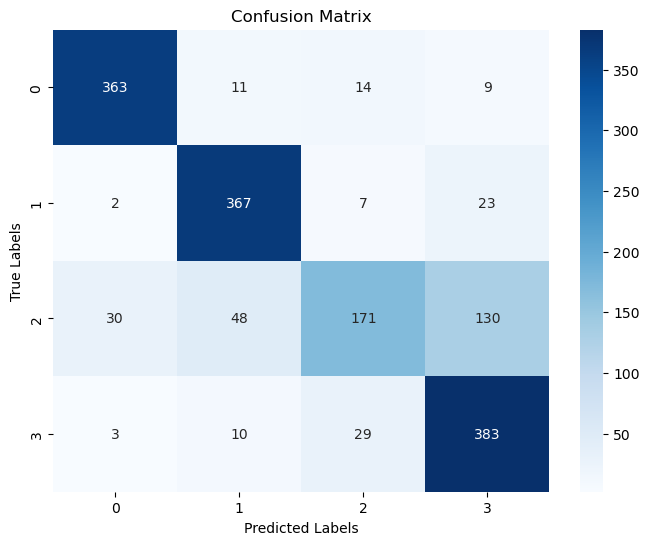

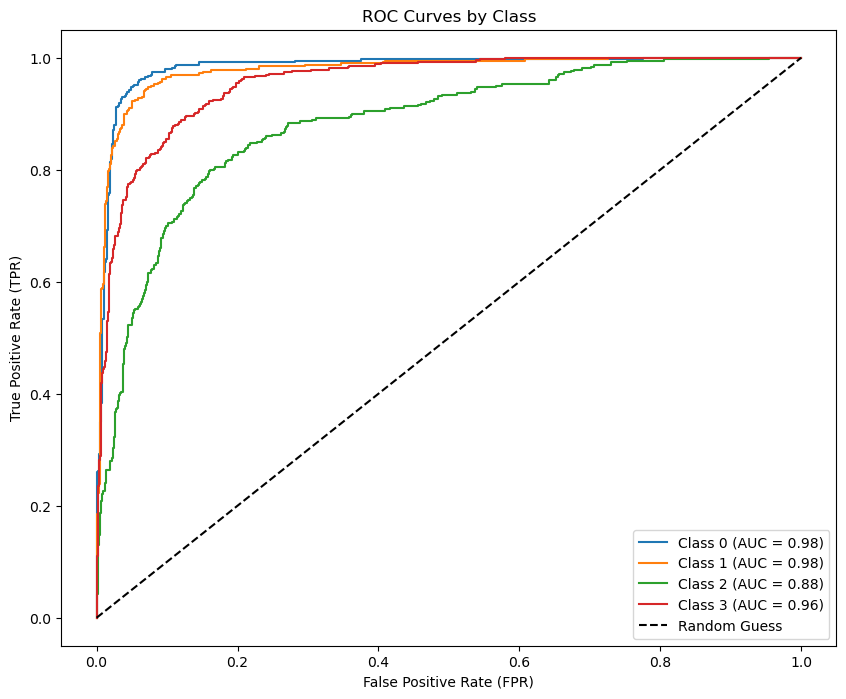

In [ ]:
print("Evaluating Model: Shallow Neural Network")
auc_scores_shallow = evaluate_model(model1, X_test, y_test)

Evaluating Model: Custom CNN
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       397
           1       0.91      0.97      0.94       399
           2       0.88      0.82      0.85       379
           3       0.92      0.92      0.92       425

    accuracy                           0.92      1600
   macro avg       0.92      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600



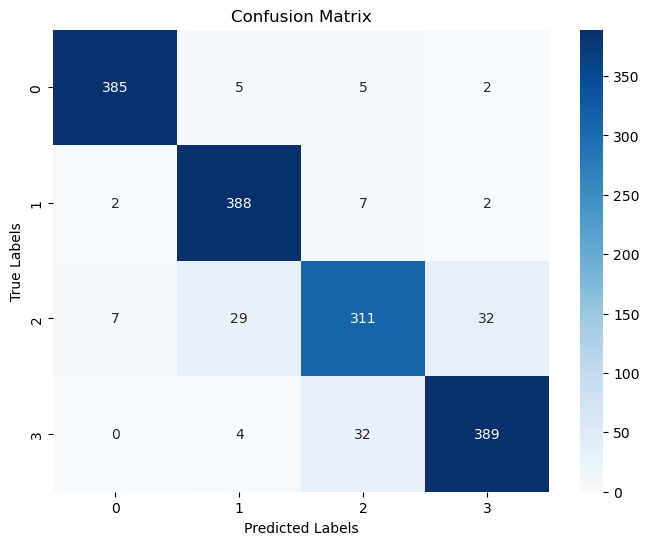

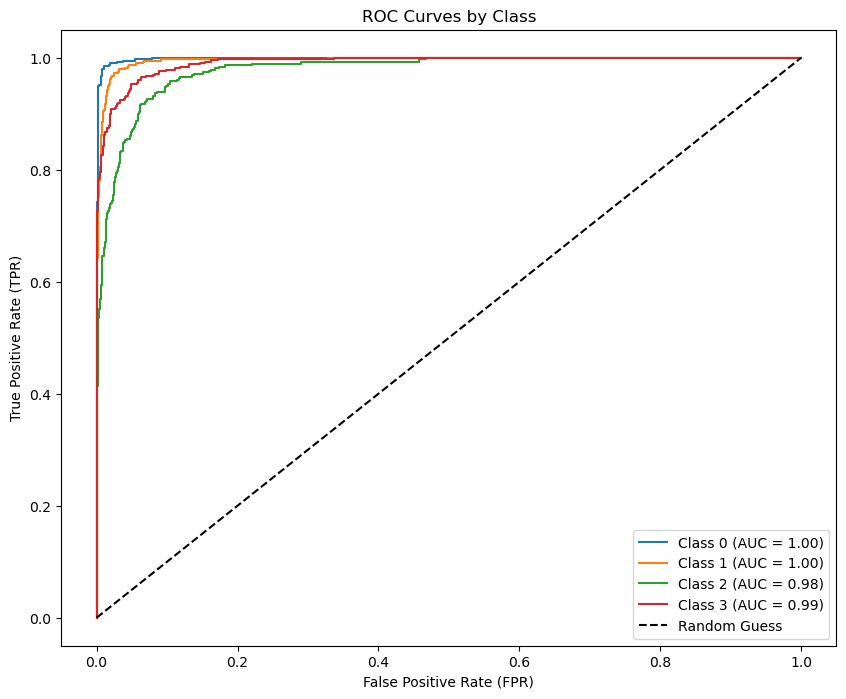

In [11]:
print("Evaluating Model: Custom CNN")
auc_scores_cnn = evaluate_model(model3, X_test, y_test)

In [14]:
best_model = results.loc[results['AUC'].idxmax()]
print("\nBest Model Selection:")
print(best_model)

print(f"\nThe best model is '{best_model['Model']}' with the highest AUC of {best_model['AUC']:.2f}.")



Best Model Selection:
Model        Custom CNN
Accuracy       0.920625
Precision      0.919826
Recall          0.91952
F1-Score       0.919191
AUC            0.990904
Name: 2, dtype: object

The best model is 'Custom CNN' with the highest AUC of 0.99.


## 3- Random Forest

The goal of this project is to classify human brain MRI images into four categories:  
1. **Glioma**  
2. **Meningioma**  
3. **No Tumor**  
4. **Pituitary**  

To achieve this goal, we will preprocess the data and train a classification model based on the **Random Forest** algorithm, known for its power and interpretability.

### Steps:
1. Preprocess the MRI dataset:
   - Resize the images to ensure a uniform size.
   - Transform the images into numerical features that can be used by the model.
   - Normalize the pixel values to optimize training performance.
2. Train a Random Forest model on the preprocessed data.
3. Evaluate the model's performance using appropriate classification metrics.

## Visualizing the Distribution of Classes

This section aims to visualize the distribution of the different brain tumor classes present in our dataset.

**Function `plot_class_distribution_from_csv`:**

This function takes as input the path to a CSV file containing information about the images and their corresponding classes. It performs the following steps:

1. **Loading the data:** The CSV file is loaded using the `pandas` library, and the data is stored in a DataFrame.
2. **Counting the classes:** The function counts the number of images belonging to each tumor class.
3. **Assigning class names:** The class names ("No Tumor", "Pituitary", "Meningioma", "Glioma") are associated with class numbers (0, 1, 2, 3) for better readability.
4. **Displaying the distribution:** The function prints the number of samples for each class in the console.
5. **Creating the chart:** A bar chart is generated to visualize the class distribution. The class names are displayed on the horizontal axis, and the number of samples is shown on the vertical axis.

**Function Call:**

The `plot_class_distribution_from_csv` function is called with the path to the CSV file containing the metadata of our dataset. This allows us to display the distribution of tumor classes in our dataset.

**Objective:**

The goal of this visualization is to understand the distribution of classes in our dataset. It allows us to check whether the classes are balanced or not, which can impact the choice and performance of our machine learning model.

Répartition des Classes :
No Tumor : 2000 échantillons
Pituitary : 2000 échantillons
Meningioma : 2000 échantillons
Glioma : 2000 échantillons


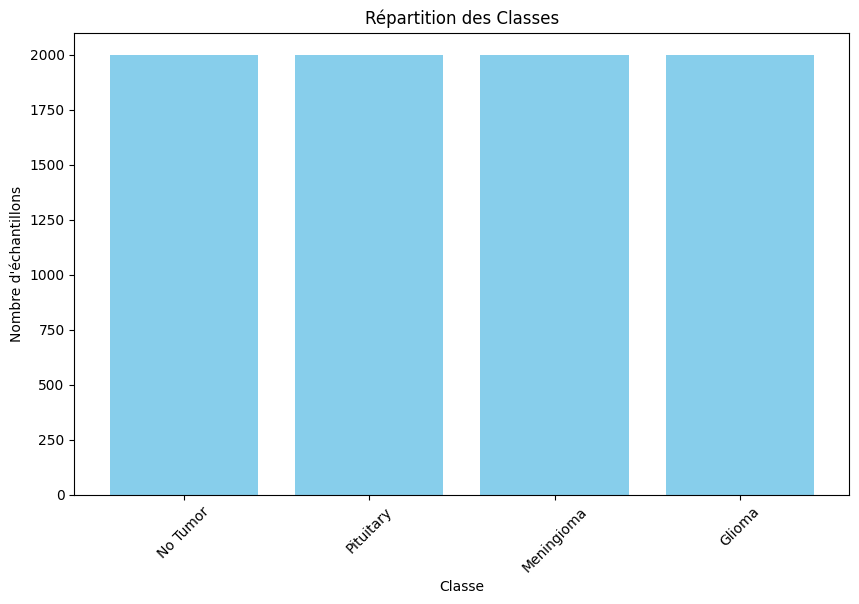

In [27]:
def plot_class_distribution_from_csv(csv_path):
    """
    Affiche la répartition des classes à partir d'un fichier CSV.

    Parameters:
    - csv_path: str, chemin vers le fichier CSV contenant les colonnes 'image_name' et 'target'.
    """
    # Charger le fichier CSV
    df = pd.read_csv(csv_path)

    # Compter le nombre d'échantillons par classe
    class_counts = df['target'].value_counts().sort_index()

    # Mapper les indices des classes à leurs noms
    class_names = {0: "No Tumor", 1: "Pituitary", 2: "Meningioma", 3: "Glioma"}
    class_counts.index = class_counts.index.map(class_names)

    # Afficher la répartition des classes
    print("Répartition des Classes :")
    for class_name, count in class_counts.items():
        print(f"{class_name} : {count} échantillons")

    # Tracer le graphique de distribution des classes
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.index, class_counts.values, color='skyblue')
    plt.title('Répartition des Classes')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.show()

# Exemple d'appel de la fonction
plot_class_distribution_from_csv('../dataset/balanced_metadata.csv')

## Loading and Preprocessing Images

This section focuses on loading brain tumor images from a directory and preparing them for use in a Machine Learning model.

**Function `load_images_from_csv`:**

This function takes as input the path to the directory containing the images and the path to a CSV file containing information about the images (image name and corresponding class). It performs the following operations:

1. **Loading metadata:** The CSV file is loaded using the `pandas` library, and the information is stored in a DataFrame.
2. **Initializing lists:** Two empty lists, `X` and `y`, are created to store the image data and their labels (classes), respectively.
3. **Iterating through images:** The function iterates through each row of the DataFrame containing the metadata. For each image:
    - The full path to the image is constructed.
    - The image is loaded using the `skimage` library.
    - **Preprocessing:**
        - The image is resized to a size of 100x100 pixels.
        - The image is converted to grayscale.
        - The image is "flattened" into a vector to be used by the Machine Learning model.
    - The image data (vector) is added to the `X` list.
    - The label (class) of the image is added to the `y` list.
4. **Conversion to NumPy arrays:** The lists `X` and `y` are converted to NumPy arrays to facilitate their use by the model.
5. **Returning the data:** The function returns the `X` (image data) and `y` (labels) arrays.

**Loading and Splitting the Data:**

1. **Defining paths:** The paths to the image directory and the CSV file are defined.
2. **Calling the function:** The `load_images_from_csv` function is called to load the image data and their labels.
3. **Splitting the data:** The data is split into training (`X_train`, `y_train`) and testing (`X_test`, `y_test`) sets using the `train_test_split` function from `scikit-learn`. Here, 80% of the data is used for training, and 20% for testing. The `random_state` parameter is set to 42 to ensure reproducibility of results.

**Objective:**

This section prepares the data for training and evaluating a Machine Learning model. The preprocessing of the images (resizing, conversion to grayscale, flattening) is crucial for optimizing the model's performance. Splitting the data into training and testing sets allows us to evaluate the model's ability to generalize on unseen data.

In [28]:
def load_images_from_csv(directory, csv_file):
    """
    Charge les images d'un répertoire et les étiquettes d'un fichier CSV.

    Parameters:
    - directory: str, chemin vers le répertoire contenant les images.
    - csv_file: str, chemin vers le fichier CSV contenant les noms d'images et leurs étiquettes.

    Returns:
    - X: numpy array de forme (nombre_échantillons, hauteur*largeur),
         contenant les données des images en vecteurs.
    - y: numpy array de forme (nombre_échantillons,), contenant les étiquettes pour chaque image.
    """
    # Charger le fichier CSV
    metadata = pd.read_csv(csv_file)

    X = []
    y = []

    # Parcourir chaque ligne du CSV
    for index, row in metadata.iterrows():
        image_name = row['image_name']
        target = row['target']

        # Créer le chemin complet vers l'image
        image_path = os.path.join(directory, image_name)

        try:
            # Chargement et prétraitement de l'image
            image = io.imread(image_path)
            image = transform.resize(image, (100, 100, 3))  # Redimensionner l'image
            image = color.rgb2gray(image)  # Convertir l'image en niveaux de gris
            X.append(image.flatten())  # Aplatir l'image en un vecteur
            y.append(target)  # Ajouter l'étiquette de l'image
        except Exception as e:
            print(f"Erreur lors du chargement de {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    return X, y

# Chemin vers le répertoire contenant les images et le fichier CSV
dataset_directory = "../dataset/balanced_dataset"
csv_file = "../dataset/balanced_metadata.csv"

# Charger les données
X, y = load_images_from_csv(dataset_directory, csv_file)

# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training and Evaluation of the Random Forest Model

This section focuses on training a Random Forest classification model and evaluating its performance.

**Model Definition and Training:**

1. **Defining the model:** A Random Forest model is created using the `RandomForestClassifier` class from the `scikit-learn` library. This model is a machine learning algorithm that uses multiple decision trees to make predictions.
2. **Training the model:** The model is trained on the training data (`X_train`, `y_train`) using the `fit` method. During this phase, the model learns the relationships between the image features (pixels) and the corresponding tumor classes.

**Model Evaluation:**

1. **Calculating accuracy:** The `score` method is used to evaluate the accuracy of the model on the test data (`X_test`, `y_test`). Accuracy represents the percentage of correct predictions made by the model.
2. **Displaying accuracy:** The model's accuracy is displayed in the console.

**Objective:**

This section aims to create, train, and evaluate a classification model for brain tumor detection. Using a Random Forest model allows for strong performance on this type of problem. Evaluating the model on test data measures its ability to generalize to new data and predict the correct tumor class for images it has never seen before.

In [29]:
# Define the Random Forest model
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data and print the accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy of Random Forest: {accuracy}")

Accuracy of Random Forest: 0.92


## Performance Analysis with a Confusion Matrix

This section aims to analyze the performance of the Random Forest model in more depth by using a confusion matrix.

**Predictions and Confusion Matrix:**

1. **Predictions:** The trained model is used to make predictions on the test data (`X_test`) using the `predict` method. The predictions are stored in the variable `y_pred`.
2. **Calculating the Confusion Matrix:** The `confusion_matrix` function from the `scikit-learn` library is used to calculate the confusion matrix. This matrix helps visualize the model's performance by comparing the predictions with the true classes of the images.
3. **Visualizing the Confusion Matrix:** The `seaborn` library is used to display the confusion matrix as a heatmap. The tumor classes are shown on the horizontal and vertical axes, and the values in the matrix represent the number of images for each combination of true class and predicted class. Annotations (numbers) in the heatmap indicate the number of images for each case.

**Interpreting the Confusion Matrix:**

- The values on the main diagonal represent correct predictions (true positives).
- The values off the diagonal represent classification errors (false positives, false negatives).
- The confusion matrix helps identify the types of errors the model makes and provides insights into its weaknesses.

**Objective:**

The goal of this section is to gain a more detailed understanding of the model's performance by visualizing classification errors. The confusion matrix provides valuable information for identifying tumor classes that are difficult for the model to distinguish and can guide efforts to improve the model.

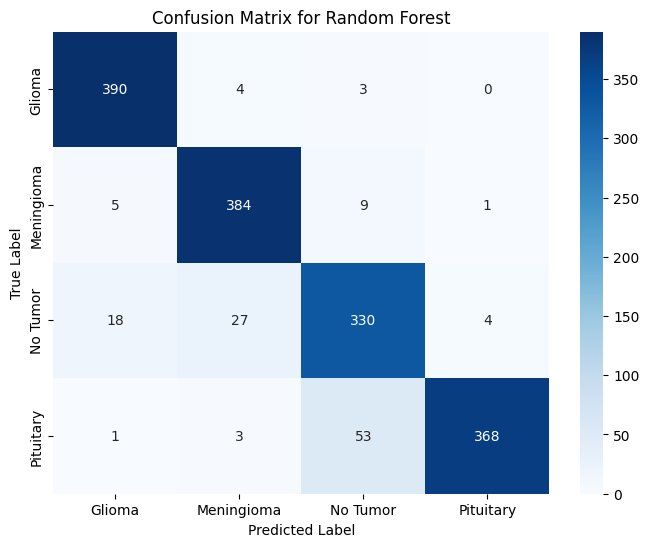

In [30]:
# Predict on the test data
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"], yticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"])
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Hyperparameter Optimization with GridSearchCV

This section focuses on optimizing the hyperparameters of the Random Forest model using the Grid Search technique (GridSearchCV).

**Defining the Search Grid:**

1. **Hyperparameter Grid:** A search grid `param_grid` is defined, containing the different values to test for the Random Forest model's hyperparameters. These hyperparameters control the model's behavior and influence its performance. The grid includes the following hyperparameters:
    - `n_estimators`: The number of trees in the forest (tested between 1 and 200, with a step of 10).
    - `max_depth`: The maximum depth of each tree (tested with `None` for no limit, or with specific values like 10, 20, 30).
    - `min_samples_split`: The minimum number of samples required to split an internal node (tested with 2, 5, 10).
    - `max_features`: The number of features to consider when looking for the best split (tested with 'sqrt', 'log2', or `None` for all features).
2. **Model Initialization:** A Random Forest model is initialized with `random_state=42` to ensure reproducibility of results.

**Grid Search:**

1. **Initializing GridSearchCV:** The `GridSearchCV` class from the `scikit-learn` library is used to perform grid search. It will test all combinations of hyperparameters defined in `param_grid` and select the best combination based on the model's performance.
2. **Configuring GridSearchCV:**
    - `estimator`: The Random Forest model to optimize.
    - `param_grid`: The grid of hyperparameters.
    - `cv`: The number of folds for cross-validation (3 in this case).
    - `scoring`: The evaluation metric used to compare the performance of the different hyperparameter combinations (here, accuracy).
    - `n_jobs`: The number of CPU cores to use for the search (`-1` to use all available cores).
    - `verbose`: The level of detail displayed during the search (1 for showing progress messages).
3. **Running the Grid Search:** The `fit` method is called to initiate the grid search on the training data (`X_train`, `y_train`).

**Results:**

1. **Displaying the Best Hyperparameters:** After the search, the best hyperparameters found are displayed in the console.
2. **Displaying the Score:** The model's score with the best hyperparameters on the training set is also displayed.

**Objective:**

The goal of this section is to optimize the performance of the Random Forest model by finding the best combination of hyperparameters. GridSearchCV automates this process by systematically testing different configurations and selecting the one that produces the best results. This helps improve the model's accuracy and its ability to generalize to new data.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Définir les plages des hyperparamètres pour la recherche par grille
param_grid = {
    'n_estimators': range(10, 201, 20),  # Nombre d'arbres (de 50 à 200 avec un pas de 50)
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale (None = aucune limite, ou des profondeurs spécifiques)
    'min_samples_split': [2, 5, 10],  # Minimum d'échantillons pour diviser un nœud
    'max_features': ['sqrt', 'log2']  # Nombre de caractéristiques pour la division (sqrt, log2 ou toutes)
}

# Initialiser le modèle RandomForest
rf = RandomForestClassifier(random_state=42)

# Initialiser GridSearchCV pour effectuer la recherche d'hyperparamètres
grid_search = GridSearchCV(
    estimator=rf,  # Modèle RandomForest
    param_grid=param_grid,  # Dictionnaire contenant les plages d'hyperparamètres
    cv=3,  # Validation croisée à 3 volets
    scoring='accuracy',  # Métrique d'évaluation (précision)
    n_jobs=-1,  # Utilisation parallèle
    verbose=1  # Afficher la progression de la recherche
)

# Lancer la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Score sur l'ensemble d'entraînement :", grid_search.best_score_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Meilleurs hyperparamètres : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 170}
Score sur l'ensemble d'entraînement : 0.9154685750013951


## Evaluation of the Optimal Model and Visualization of Results

This section focuses on evaluating the model with the best hyperparameters found by GridSearchCV and visualizing the results of the search.

**Evaluating the Optimal Model:**

1. **Extracting the Best Model:** The best model found by GridSearchCV is retrieved using the `best_estimator_` attribute and stored in the `best_model` variable.
2. **Evaluating on Test Data:** The performance of the best model is evaluated on the test data (`X_test`, `y_test`) using the `score` method. This allows us to measure the accuracy of the model on data it has never seen before.
3. **Displaying the Score:** The model's score on the test set is displayed in the console.

**Visualizing the Results of the Grid Search:**

1. **Extracting the Results:** The results of the grid search are extracted and stored in a `pandas` DataFrame.
2. **Filtering the Results:** The DataFrame is filtered to retain only the columns containing information about the hyperparameters `n_estimators` and `max_depth`, as well as the average model performance (`mean_test_score`).
3. **Creating a Pivot Table:** A pivot table is created to organize the results based on the values of `n_estimators` and `max_depth`.
4. **Visualizing the Pivot Table:** The pivot table is visualized as a heatmap using the `matplotlib` library.  
    - The horizontal axis represents the number of trees (`n_estimators`).
    - The vertical axis represents the maximum depth of the trees (`max_depth`).
    - The colors represent the average model performance (accuracy) for each combination of hyperparameters.
    - A color bar is displayed to facilitate the interpretation of the colors.

**Objective:**

The objectives of this section are twofold:

1. **Evaluate the Optimal Model's Performance:** By testing the best model on the test data, we obtain a more realistic estimate of its ability to generalize to new data.
2. **Visualize the Impact of Hyperparameters:** Visualizing the results of GridSearchCV helps understand the influence of the hyperparameters `n_estimators` and `max_depth` on the model's performance. This can help better understand the model's behavior and identify areas where adjustments might be beneficial.

Score sur l'ensemble de test : 0.916875


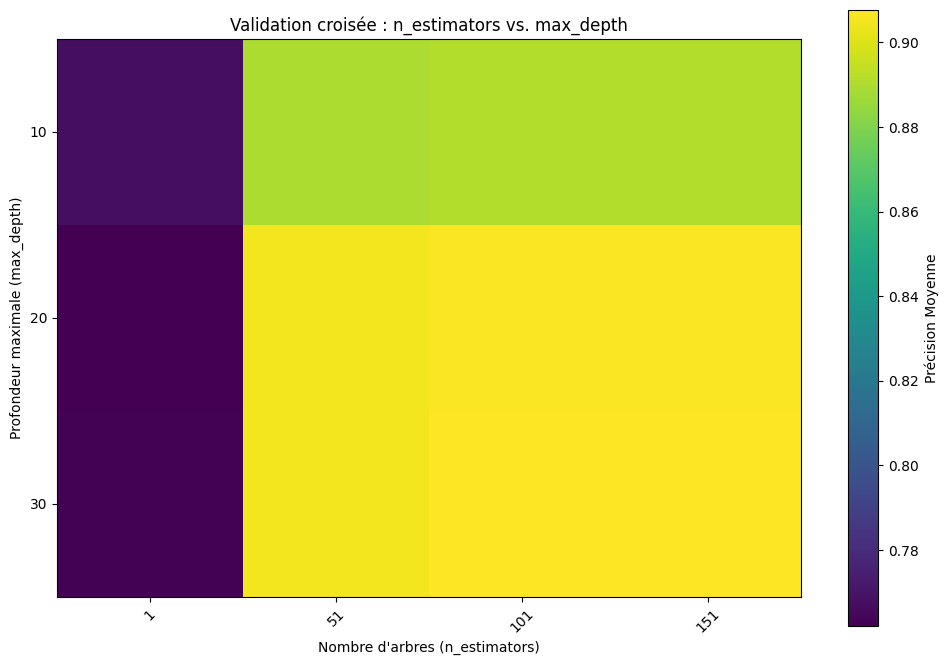

In [32]:
# Tester le modèle optimal sur les données de test
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Score sur l'ensemble de test :", test_accuracy)

# Extraire les résultats de GridSearch pour les visualiser
results = pd.DataFrame(grid_search.cv_results_)

# Grouper par les combinaisons de paramètres et calculer la moyenne des scores
results_filtered = results_filtered.groupby(['param_n_estimators', 'param_max_depth'], as_index=False)['mean_test_score'].mean()

# Créer le pivot
pivot_results = results_filtered.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(12, 8))
plt.imshow(pivot_results, interpolation='nearest', cmap='viridis')
plt.colorbar(label="Précision Moyenne")
plt.title("Validation croisée : n_estimators vs. max_depth")
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Profondeur maximale (max_depth)")
plt.xticks(range(len(pivot_results.columns)), pivot_results.columns, rotation=45)
plt.yticks(range(len(pivot_results.index)), pivot_results.index)
plt.show()

# Conclusion

The **Random Forest (RF)** model surprisingly delivered strong performance despite being traditionally less common for image classification tasks. While deep learning models are typically favored for their ability to extract complex features from image data, Random Forest demonstrated that it can still compete effectively, especially when computational efficiency is a priority. The training time required for Random Forest was significantly lower compared to deep learning models, which makes it an attractive option in scenarios where fast training and lower resource usage are crucial.

The **simple neural network** model was the fastest to train but struggled with detecting complex patterns within the image data. This highlights its limitation in image classification tasks, where more sophisticated models are often needed to capture intricate details present in medical imaging.

**MobileNetV2** struck the best **balance between speed and accuracy**. Being a lightweight deep learning model designed for mobile devices, it offered good performance while requiring less computational power compared to heavier architectures like traditional CNNs. It is an ideal choice when you need both precision and efficiency, especially in real-time or resource-limited environments.

The **custom CNN** performed well on sufficient data, excelling in capturing complex image features. However, it came at the cost of **longer training times** and higher computational demands. This can be a significant drawback, particularly when faster deployment and real-time prediction are important factors.

In conclusion, while deep learning models like **MobileNetV2** or **CNN** offer a **good trade-off between speed and accuracy**, **Random Forest** showed surprisingly **strong performance**, especially when considering its faster training time and lower resource requirements. This emphasizes the importance of choosing the right model based on the trade-off between **accuracy** and **computational time**, which can vary depending on the use case.

### Our choice is **Random Forest** because:

- It provides **good performance** for image classification without the complexity and high resource usage of deep learning models.
- It is **fast to train**, making it a time-efficient choice, especially for large datasets.
- It is **less computationally intensive**, suitable for environments with limited hardware resources.
- It offers **better interpretability** compared to deep learning models, which is crucial for tasks that require transparency, such as medical diagnoses.

In summary, **Random Forest** is an efficient and robust solution, especially when the goal is to balance **accuracy** with **processing time**, making it an excellent choice for image classification tasks with constrained resources.